# Reinforcement learning: Markov Chains

The examples are based on Enes Bilgin's book [Mastering Reinforcement Learning with Python ](https://www.packtpub.com/product/mastering-reinforcement-learning-with-python/9781838644147)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

# Grid world example

### Grid world example

Let's start exploring RL with a robot that is moving through a grid world and that's all it does. Because the robot's battery is empty, its moves are erratic, that is if the action is *move down* the robot moves in either direction with a certain probability.

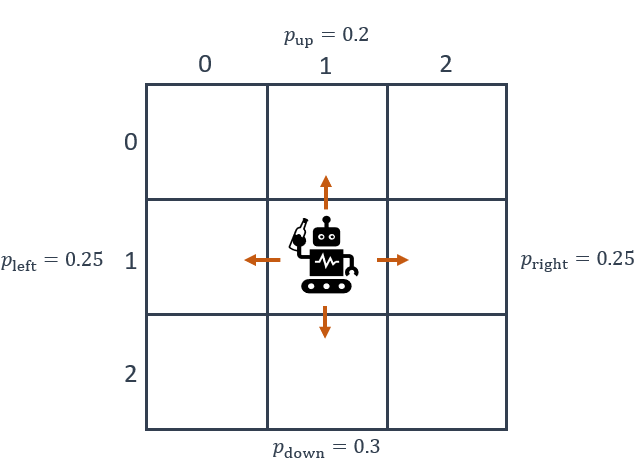




What we will do now is take a look at the transition probability matrix *P*, and how it changes after a number of steps. For simplicity, we assume that the robot starts always from the center position. Also, if the robot hits a wall, it just stays in its position. 

In [14]:
# parameters of the grid world

grid_length = 3
num_fields = grid_length ** 2

# initial probability distribution
q = np.zeros(num_fields)  
q[num_fields // 2] = 1
print(q)  # the robot is currently in the middle of the grid world at (1,1) or 4

[0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [15]:
# next, we define a function for the 3x3 transition probability matrix P

def get_P(grid_length, num_fields, p_up, p_down, p_left, p_right):
    P = np.zeros((num_fields, num_fields))
    grid_map = {i+1: (i//grid_length, i%grid_length) for i in range(num_fields)}

    for i in range(num_fields):
        for j in range(num_fields):
            row_start, column_start = grid_map[i+1]
            row_end, column_end = grid_map[j+1]

            vertical_diff =  row_start - row_end
            horizontal_diff = column_start - column_end

            # sort out the allowed movements and assign their transition probabilites
            if vertical_diff == 0:  # robot doesn't move vertically (up or down)
                if horizontal_diff == 1:  # robot moves left (from (1,1) to (2,1))
                    P[i,j] = p_left
                elif horizontal_diff == -1:  # robot moves right
                    P[i,j] = p_right
                elif horizontal_diff == 0: # if there is no movement the robots hit a wall
                    if row_start == 0:  # hitting the upper wall
                        P[i,j] += p_up  
                    elif row_start == (grid_length-1):  # hitting the lower wall
                        P[i,j] += p_down  
                    if column_start == 0:  # hitting the left wall
                        P[i,j] += p_left
                    elif column_start == (grid_length-1):  # hitting the right wall
                        P[i,j] += p_right

            elif vertical_diff == 1:  # the robot moves up 
                if horizontal_diff == 0:
                    P[i,j] += p_up
            elif vertical_diff == -1:  # the robot moves up 
                if horizontal_diff == 0:
                    P[i,j] += p_down
    return P

P = get_P(grid_length, num_fields, p_up=0.2, p_down=0.3, p_left=0.25, p_right=0.25)
print(P)

[[0.45 0.25 0.   0.3  0.   0.   0.   0.   0.  ]
 [0.25 0.2  0.25 0.   0.3  0.   0.   0.   0.  ]
 [0.   0.25 0.45 0.   0.   0.3  0.   0.   0.  ]
 [0.2  0.   0.   0.25 0.25 0.   0.3  0.   0.  ]
 [0.   0.2  0.   0.25 0.   0.25 0.   0.3  0.  ]
 [0.   0.   0.2  0.   0.25 0.25 0.   0.   0.3 ]
 [0.   0.   0.   0.2  0.   0.   0.55 0.25 0.  ]
 [0.   0.   0.   0.   0.2  0.   0.25 0.3  0.25]
 [0.   0.   0.   0.   0.   0.2  0.   0.25 0.55]]


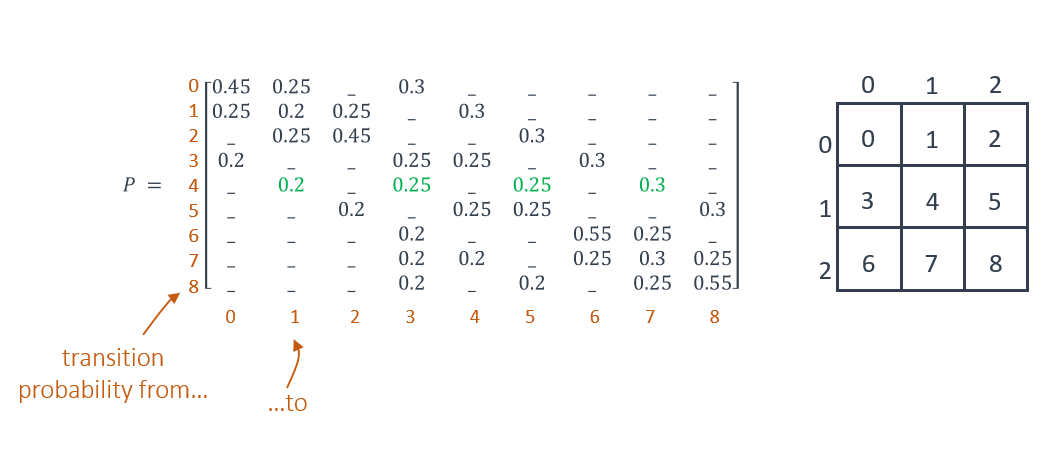

### Calculating the n-step transition probabilites

Using the above function and the formula for caluculating the transition probabilities after $n$ steps we can see how the transition probabilites converge over time. 

Probability of the system being in state $i$ after $n$ steps:  

$ p_n = qP^n$,

where $q$ is the initial probability distribution (which in our case is: [0,0,0,0,1,0,0,0,0]) and $P^n$ is the transition probability matrix raised to the power $n$. Hence, $P^n_{ij}$ gives the probability of being in state $j$ after $n$ steps when started in state $i$.

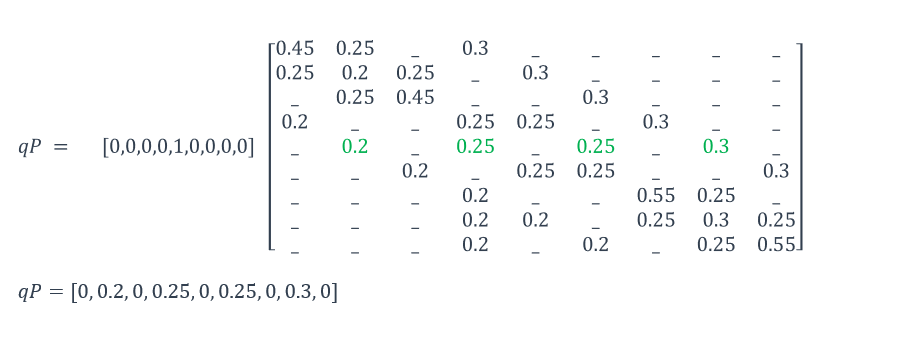


In [16]:
def q_Pn(n):
    Pn = np.linalg.matrix_power(P, n)
    return np.round(np.matmul(q, Pn), 3)

print(q_Pn(1), '\n')
print(q_Pn(2), '\n')
print(q_Pn(5), '\n')
print(q_Pn(10), '\n')
print(q_Pn(100), '\n')

[0.   0.2  0.   0.25 0.   0.25 0.   0.3  0.  ] 

[0.1   0.04  0.1   0.062 0.245 0.062 0.15  0.09  0.15 ] 

[0.074 0.083 0.074 0.113 0.094 0.113 0.146 0.157 0.146] 

[0.072 0.072 0.072 0.105 0.106 0.105 0.156 0.156 0.156] 

[0.07  0.07  0.07  0.105 0.105 0.105 0.158 0.158 0.158] 



The transition probability matrices show us how fast the dynamics of the Markov chain converge and that the robot has the highest probability to be in the lower cells, because $p_{down} > p_{left/right} > p_{up}$  

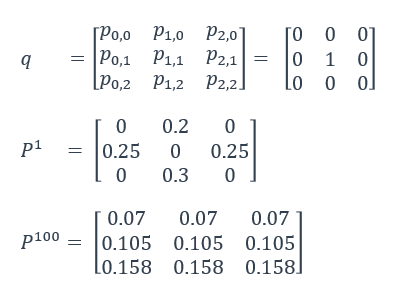

In [17]:
state = 8
n = 10 ** 6
visited_states = [state]
for t in range(n):
    state = np.random.choice(num_fields, p=P[state, :])
    visited_states.append(state)
    
np.unique(visited_states, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 69721,  70082,  69948, 104241, 104879, 105830, 158479, 158351,
        158470], dtype=int64))

## Markov Reward Process

Before we looked at Markov chains, which describe a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.

Now, we will look at Markov reward processes, that is we will add rewards and hereby calculate the value of the different states with their transition probabilities. For this purpose, we will change our grid word: Now, if the robot hits a wall, it crashes and thus the robot collects only rewards so long as it moves through the world. It gets +1 reward for every time step. 

In [18]:
# modify the transition probability matrix to account for crashes 

P = np.zeros((num_fields+1, num_fields+1))  # add a new state to the prob. transition matrix for crashed 
P[:num_fields, :num_fields] = get_P(grid_length, num_fields, p_up=0.2, p_down=0.3, p_left=0.25, p_right=0.25)
print(P, '\n')
for i in range(num_fields):
    P[i, num_fields] = P[i, i]  # if a wall is hit, the new state is the crash state
    P[i,i] = 0  # now, the states don't transition to themselves if a wall is hit thus the trans. prob. is zero
P[num_fields, num_fields] = 1  # the crash state is an absorbing state that only transitions to itself
print(P)

[[0.45 0.25 0.   0.3  0.   0.   0.   0.   0.   0.  ]
 [0.25 0.2  0.25 0.   0.3  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.45 0.   0.   0.3  0.   0.   0.   0.  ]
 [0.2  0.   0.   0.25 0.25 0.   0.3  0.   0.   0.  ]
 [0.   0.2  0.   0.25 0.   0.25 0.   0.3  0.   0.  ]
 [0.   0.   0.2  0.   0.25 0.25 0.   0.   0.3  0.  ]
 [0.   0.   0.   0.2  0.   0.   0.55 0.25 0.   0.  ]
 [0.   0.   0.   0.   0.2  0.   0.25 0.3  0.25 0.  ]
 [0.   0.   0.   0.   0.   0.2  0.   0.25 0.55 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]] 

[[0.   0.25 0.   0.3  0.   0.   0.   0.   0.   0.45]
 [0.25 0.   0.25 0.   0.3  0.   0.   0.   0.   0.2 ]
 [0.   0.25 0.   0.   0.   0.3  0.   0.   0.   0.45]
 [0.2  0.   0.   0.   0.25 0.   0.3  0.   0.   0.25]
 [0.   0.2  0.   0.25 0.   0.25 0.   0.3  0.   0.  ]
 [0.   0.   0.2  0.   0.25 0.   0.   0.   0.3  0.25]
 [0.   0.   0.   0.2  0.   0.   0.   0.25 0.   0.55]
 [0.   0.   0.   0.   0.2  0.   0.25 0.   0.25 0.3 ]
 [0.   0.   0.   0.   0.   0.2  0.   0.25 0

In [19]:
# now, we assign rewards to the transitions from one state to another

n = 1000 # 10**5
avg_rewards = np.zeros(num_fields)
for state in range(9):  # calculate a reward for all cells
    for i in range(n):  # average over n rewards
        crashed = False
        next_state = state
        episode_reward = 0
        while not crashed:
            # generates a non-uniform random sample from the possible next states 
            # print(P[next_state, :], '\n')
            next_state = np.random.choice(num_fields + 1, p=P[next_state, :])  
            if next_state < num_fields:
                episode_reward += 1
            else:
                # if crashed, the episode is terminated 
                crashed = True
        avg_rewards[state] += episode_reward
avg_rewards /= n  # average the rewards 
print(avg_rewards)

[1.919 2.749 1.975 2.397 3.426 2.359 1.443 2.061 1.391]


In [20]:
#Start from S2:
#most likely trajectory
#S2->S5->S8->

#S3


### Questions: 
- If the robot starts from the center of the grid, what is the most probable trajectory $(S_0, A_0, S_1, A_1, ...)$
- For state $s_3$, what are the possible actions and transition probabilities?
- Sketch a transition graph for the grid world, one for the basic setup and one including the crash state
- How can you implement a transition probability matrix where hitting a wall results in a crash only 50% of the time? How does that change the rewards?